In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import sys
sys.path.append("../")

from utils import *
from model import *
import dataloader
import matplotlib.pyplot as plt
import numpy as np
from glob import glob


### Load the dataset

In [3]:
batch_size = 50

x,y,free_field,free_field_freq = dataloader.load_file_frequency(sample_num=400,type="scatter_field_f")
x_train = torch.tensor(x[:350*50,:,:,:]).float()
x_test = torch.tensor(x[350*50:,:,:,:]).float()
y_train = torch.tensor(y[:350*50,:,:,:]).float()
y_test = torch.tensor(y[350*50:,:,:,:]).float()

x_normalizer = dataloader.UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = dataloader.UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)
y_test = y_normalizer.encode(y_test)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

### Evaluation script

In [4]:
def plot_all(model,loader,plot=False):
    with torch.no_grad():
        for i, (x,y) in enumerate(loader):
            x, y = x.cuda(), y
            batch_size = x.shape[0]
            out = model(x).reshape(batch_size, 63, 63,2)
            if i==0:
                loss_fno_train = (((out.cpu()-y)**2)).mean(axis=[1,2,3])
            else:
                loss_fno_train += (((out.cpu()-y)**2)).mean(axis=[1,2,3])
        loss_fno_train = loss_fno_train/len(loader)
        
    print("train mse:",loss_fno_train)
    if plot:
        out = out.detach().cpu().numpy()
        y = y.detach().cpu().numpy()
        src_z,src_x= [56,31]
        src_array = np.zeros([63,63])
        src_array[src_z,src_x] = -1
        plt.figure(figsize=[20,3])
        for idx,src_x in enumerate(range(3,60,10)):
            plt.subplot(1,6,idx+1)
            plt.plot(out[:,src_z,src_x,0])
            plt.plot(out[:,src_z,src_x,1])

            plt.plot(y[:,src_z,src_x,0],"--",linewidth=3)
            plt.plot(y[:,src_z,src_x,1],"--",linewidth=3)
            plt.title("total, x:{},z:{}".format(src_z,src_x))

            src_array[src_z,src_x] = 1
        plt.tight_layout()

        plt.figure(figsize=[3,3])
        plt.plot(loss_fno_train.detach().cpu().numpy())
        plt.ylabel("frequency")
        plt.title("fno error at each frequency")
        plt.show()
    return loss_fno_train


### Load forward model and evaluate

train mse: tensor([0.0013, 0.0013, 0.0013, 0.0013, 0.0014, 0.0014, 0.0015, 0.0016, 0.0018,
        0.0020, 0.0022, 0.0025, 0.0029, 0.0033, 0.0038, 0.0042, 0.0047, 0.0051,
        0.0053, 0.0056, 0.0058, 0.0061, 0.0064, 0.0065, 0.0067, 0.0069, 0.0071,
        0.0075, 0.0079, 0.0086, 0.0093, 0.0101, 0.0107, 0.0113, 0.0121, 0.0130,
        0.0139, 0.0149, 0.0160, 0.0172, 0.0185, 0.0198, 0.0212, 0.0226, 0.0240,
        0.0254, 0.0268, 0.0285, 0.0307, 0.0334])


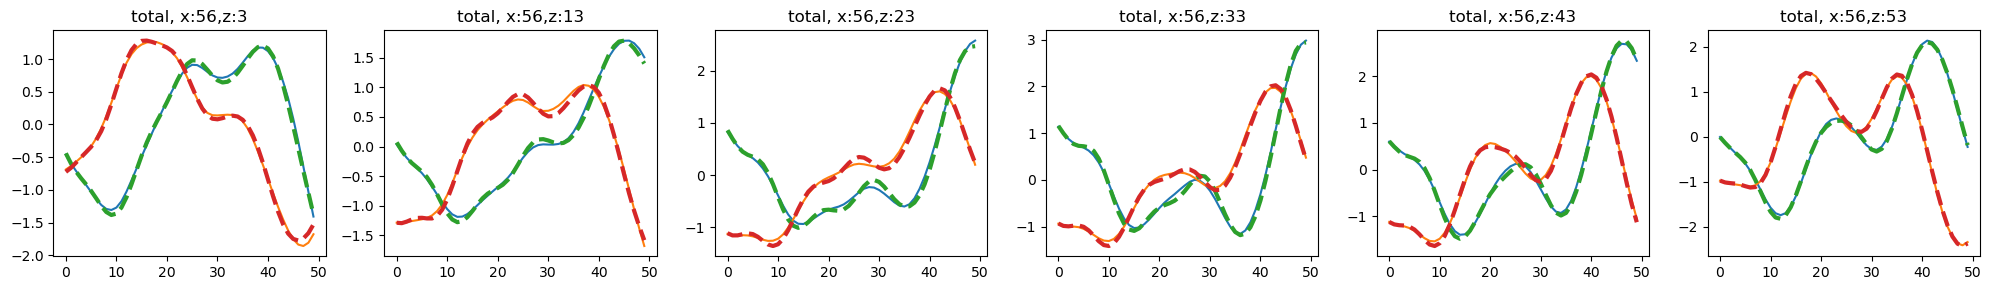

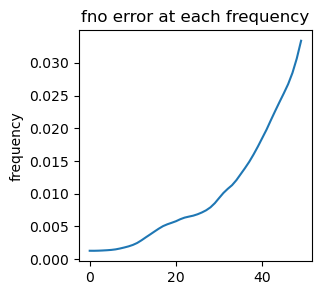

In [5]:
logdir = glob("../model_zoo/forward_model/*/fno_vanilla_5_128_350_50_current.pth")[0]
model = (torch.load(logdir)).cuda()
model.eval()
errors_test = {}
error = plot_all(model,test_loader,plot=True)
errors_test[logdir.split("fno_",2)[1]]=error

train mse: tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0011, 0.0011, 0.0012, 0.0013, 0.0015,
        0.0016, 0.0018, 0.0020, 0.0023, 0.0027, 0.0031, 0.0034, 0.0039, 0.0042,
        0.0045, 0.0048, 0.0050, 0.0052, 0.0054, 0.0057, 0.0061, 0.0065, 0.0070,
        0.0073, 0.0077, 0.0081, 0.0086, 0.0092, 0.0098, 0.0102, 0.0107, 0.0113,
        0.0120, 0.0128, 0.0138, 0.0148, 0.0157, 0.0167, 0.0178, 0.0187, 0.0196,
        0.0203, 0.0213, 0.0226, 0.0246, 0.0272])


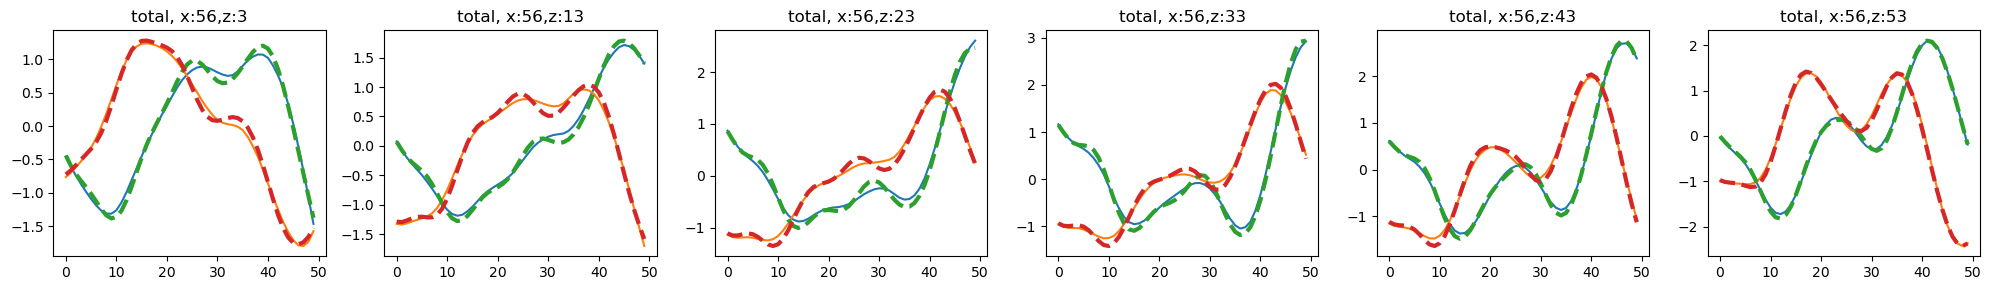

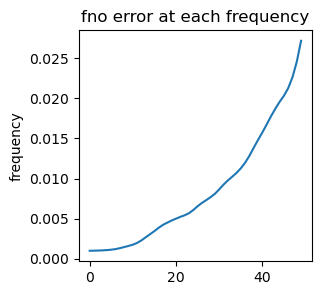

In [6]:
logdir = glob("../model_zoo/forward_model/*/fno_born_5_128_350_50_current.pth")[0]
model = (torch.load(logdir)).cuda()
model.eval()
error = plot_all(model,test_loader,plot=True)
errors_test[logdir.split("fno_",2)[1]]=error

vanilla_5_128_350_50_current.pth tensor(0.0101)
born_5_128_350_50_current.pth tensor(0.0085)


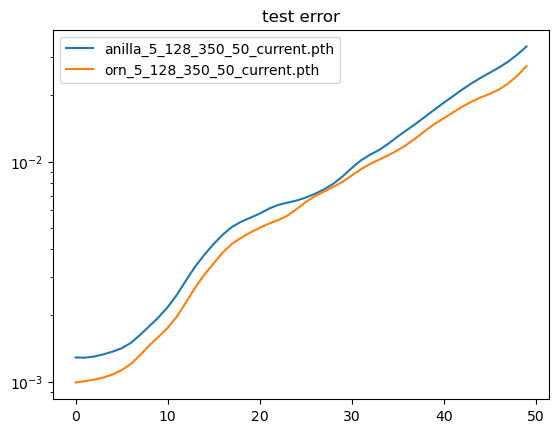

In [7]:
for key in errors_test.keys():
    plt.plot(errors_test[key],label=key[1:])
    print(key,errors_test[key].mean())
plt.legend()
plt.title("test error")
plt.yscale("log")
plt.show()